<h1 align="center">Programming Skills Assessment 2</h1>
<h2 align="center">Performance experiments</h2>
<h6 align="center">by <i>Miguel Sozinho Ramalho, s2004624</i> - <i>1st semester, 19/20</i></h6>

# 1 - Introduction
<!--Short introduction to the rest of the report.-->
The present report describes a performance experiment on the previously developed code for the **percolation** problem. As defined in earlier work, the problem consists of generating a randomly filled grid and then testing if there are paths of empty cells connecting the top of the grid with the bottom of the grid. 

This problem was solved in C and the compiled executable `main.out` (as a result of running the `make` command for the provided `Makefile` on the `code` folder) can receive the following parameters:
* `-g` which is the grid size, ie. the number of rows (or columns as it is a square grid) [`default=20`]
* `-s` the value to use for the seed [`default=1564`]
* `-r` the value for `rho` aka density of filled cells in the grid (`[0,1]`) [`default=0.4`]
* `-m` the maximum number of clusters to show, if not present all clusters are displayed
* `-d` the name of the `.dat` file to output the grid to  [`default=map.dat`]
* `-p` the name of the `.pgm` file to output the grid (in a pgm format) to [`default=map.pgm`]

The present report focuses on the performance evolution (measure in terms of execution time of the compiled code) as a function of both the density/filled cells (rho or `-r`) and grid size (`-g`). 

### 1.1 - Report environment
The report is developed as a [Jupyter Notebook](https://jupyter.org/) (using the Python language) which is considered to be a more flexible way of explaining the methodology and results achieved while keeping the formality of a report, when compared to traditional static reports. Moreover, the deliverable for this project is a PDF of the notebook, as per the specification, but the original notebook (`performance_report.ipynb`) and the utilities file (`utils.py`) used for the performance execution can be found in the assignment 2 code submission (for Part 1 - testing) under the `performance` folder.

### 1.2 - Structure
The remaning of this report is organized in the following sections:
 * Method: which goes over the process used for compiling, running and measuring the C code.
 * Results: where relevant plots are created and displayed
 * Discussion: where the previous section results are discussed
 * Conclusion: which is dedicated to a reflection process and proposal of future performance experiments ideas

# 2 - Method
<!-- Description of how you carried out your experiment, what your set up was, how you collected data. -->
This section will do a step-by-step explanation of how the experiment was carried out and in what context it was executed.

### 2.1 - Context
Here are some explicit details of the environment in which the code performance tests were executed:
 * **Machine hardware:**
     * Processor: Intel(R) Core(TM) i5-8625U CPU @ 1.60GHz
     * RAM: 16GB
     * System Type: 64bit OS, x64-based processor
 * **OS:** Windows Subsystem for Linux (from Windows 10)
 * **Software version:** Python 3.6.8
 
 The remaining of the section will describe other relevant details such as _third party tools_ and _data collection techniques_.
 
### 2.2 - Third party tools
Below are the included third party tools and their purpose.

In [1]:
# Data handling
import numpy as np

In [2]:
# Data Visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
# Experiment execution progress visualization
from tqdm.notebook import tqdm

In [4]:
# Python libraries used for the experiments
import random # generate random seeds to avoid biases to a given seed
random.seed(a=None) # set the seed to the current system time
import resource # to measure the real execution time of the user proce

In [5]:
# User-defined utility functions to execute bash commands from Python
from utils import custom_subprocess, make_project

### 2.3 - Experiment

Initially, we compile the latest version of the code.

In [6]:
make_project()

Compilation successfull


Then, we choose what values to test for both variables under scrutiny: grid size and density (rho).

In [7]:
grids = list(range(0, 501, 10))
print("Using %d different values for grid size:" % len(grids))
print(grids)

Using 51 different values for grid size:
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]


In [8]:
rhos = list(np.linspace(0, 1, 21))
print("Using %d different values for density:" % len(rhos))
print(rhos)

Using 21 different values for density:
[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0]


In [9]:
print("Total combinations to explore: %d" % (len(grids) * len(rhos)))

Total combinations to explore: 1071


We then define a function `execute_and_time` which receives individual values for `grid` and `rho` and is capable of calling the executable `main.out` with those values as parameters and also includes a randomly generated `seed` (so as to avoid using a static seed and increase the danger of entering a biased experiment).

This function then takes the real time usage of the system call, in seconds, and returns it.

In [10]:
def execute_and_time(grid, rho, silent=True):
    # define the parameters to use when calling main.out
    params = ["../code/main.out", "-g %d" % grid, "-r %.10f" % rho, "-s %d" % random.randint(0, 1e4)]
    # measure time at start
    usage_start = resource.getrusage(resource.RUSAGE_CHILDREN).ru_utime
    # execute code
    custom_subprocess(params, silent)
    # measure time at end and return difference
    return resource.getrusage(resource.RUSAGE_CHILDREN).ru_utime - usage_start

After this, we follow to create a list of (`i, j, grid, rho`) for all possible combinations of `grids` and `rhos`. In this list:
 * `i` is the index of the current `grid` value in the `grids` list
 * `j` is the index of the current `rho` value in the `rhos` list

In [11]:
combs = [(i, j, grid, rho) for i, grid in enumerate(grids) for j, rho in enumerate(rhos)]
print("Confirming the number of combinations: %d" % len(combs))
print("first combination: %s" % str(combs[0]))
print("last combination: %s" % str(combs[-1]))

Confirming the number of combinations: 1071
first combination: (0, 0, 0, 0.0)
last combination: (50, 20, 500, 1.0)


Now, we create a zeroed matrix of dimensions `len(grids)` x `len(rhos)` that will eventually contain the execution times for each pair of combinations.

In [12]:
times = np.zeros((len(grids), len(rhos)), dtype=int).tolist()

Following this, we will now iterate over each of the combinations and fill the `times` matrix cells with the corresponding execution time.

[`tqdm`](https://github.com/tqdm/tqdm) is used to provide a progress bar given that the experiments can run over several minutes.

In [13]:
for i, j, g, r in tqdm(combs):
    times[i][j] = execute_and_time(g, r)

# 3 - Results
<!-- Your results, including a clear graphical presentation of any performance data. -->
Now that we have computed the execution times and saved them in the `times` variable, we can obtain some interesting results from them. 

Firstly, we will plot a 2D countour plot where `rho` is our x-axis, `grid` is our y-axis and the colour describes the execution time for each measure point. Although it is impossible to measure over a continuous value, the values we have are sufficient to trace the countours and identify similar-execution-time areas. This is Figure 1.

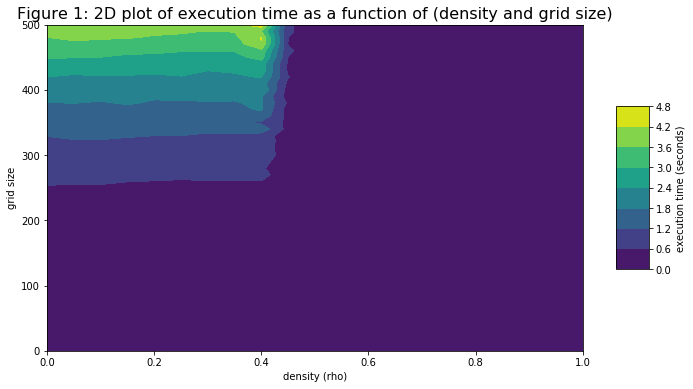

In [14]:
# create the figure with accurate descriptions
plt.figure(figsize=(12, 6))
plt.title("Figure 1: 2D plot of execution time as a function of (density and grid size)", size=16)
plt.xlabel('density (rho)')
plt.ylabel('grid size')
# plot the data
plt.contourf(rhos, grids, times)
# customize the righ side color bar
cb = plt.colorbar(shrink=0.5, aspect=5)
cb.set_label("execution time (seconds)")

Secondly, we are going to visualize the same patterns but in a tri-dimensional manner, where we still have a colour describing the execution time for the combination of parameters but now height also illustrates the execution time. This is Figure 2.

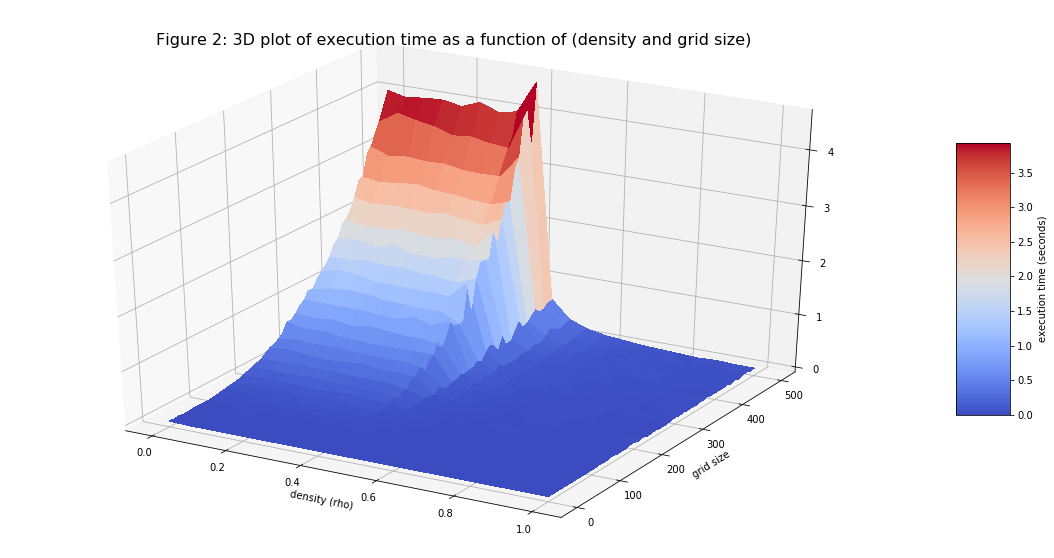

In [15]:
# create the figure with accurate descriptions
fig = plt.figure(figsize=(20, 10))
ax = fig.gca(projection="3d")
ax.set_title("Figure 2: 3D plot of execution time as a function of (density and grid size)", size=16)
plt.xlabel("density (rho)")
plt.ylabel("grid size");
# convert into appropriate format and then plot the data
X, Y = np.meshgrid(np.array(rhos), np.array(grids))
Z = np.array(times)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# customize the righ side color bar
cb = fig.colorbar(surf, shrink=0.5, aspect=5)
cb.set_label("execution time (seconds)")

Thirdly, we are going to project the previous curve in a scatter plot so that we can compare how time execution varies with each of the parameters. 

To achieve this, we take the average of the execution times for each value of the parameter being plotted, from the `times` matrix, which is an average of each column for the density study, and of the rows for the grid size study.

These plots compose Figure 3 (Figures 3.1 to 3.6).

In [16]:
def plot_custom_scatter(ax, num, X, Y, name, ylabel=False):
    param = "grid size" if ylabel else "density"
    ax.scatter(X, Y, c="m")
    if ylabel: ax.set_ylabel("execution time(seconds)", size=14)
    ax.set_title("Figure %s: %s execution time vs %s" % (num, name, param), size=16)
    ax.set_xlabel(param, size=14)

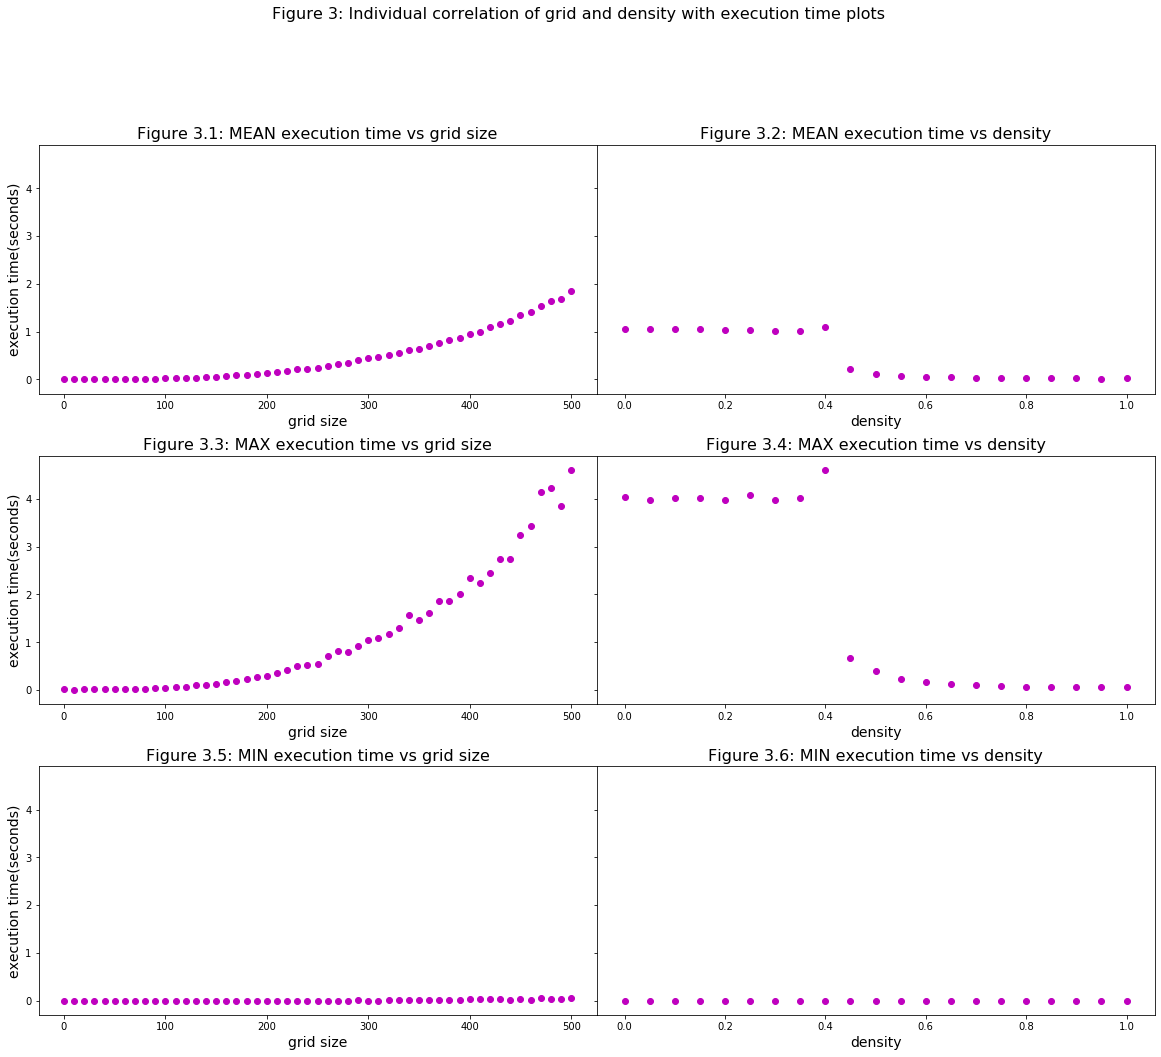

In [17]:
# create the figure with accurate descriptions
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharey=True, figsize=(20,16))
fig.subplots_adjust(wspace=0, hspace=0.25)
fig.suptitle("Figure 3: Individual correlation of grid and density with execution time plots", fontsize=16, y=1);
# plot each subplot
plot_custom_scatter(ax1, "3.1", grids, np.mean(times, axis=1), "MEAN", True)
plot_custom_scatter(ax2, "3.2", rhos,  np.mean(times, axis=0), "MEAN")
plot_custom_scatter(ax3, "3.3", grids, np.max(times, axis=1), "MAX", True)
plot_custom_scatter(ax4, "3.4", rhos,  np.max(times, axis=0), "MAX")
plot_custom_scatter(ax5, "3.5", grids, np.min(times, axis=1), "MIN", True)
plot_custom_scatter(ax6, "3.6", rhos,  np.min(times, axis=0), "MIN")

# 4 - Discussion
<!-- Analysis and discussion of your results.-->
This section is dedicated to interpreting and discussing the previously obtained results.

### 4.1 - Time complexity
The analysis of the time of complexity of this problem is not straightforward, but we can identify the methods which are most costly in terms of time complexity, namely:
* `fillGridRandomly`, `percolates`, `writeGridToPgmFile` and `computeClusterSize` are functions with  two nested for-loops over the grid size, meaning they share the same time complexity of $O(N^2)$
* `convergeOnMaxCluster` which also has two nested loops, also has a while-loop surrounding them, meaning the $O(N^2)$ operation will execute $C$ times, where C is the number of iterations the grid requires so that all cells have converged on their respective cluster. Although calculating $C$ is not trivial, we can conclude that this function has a time complexity of $O(C \times N^2)$
* most of the remaining functions have a complexity of $O(N)$ or less

Given all of the above, and the fact that no function besides `convergeOnMaxCluster` has a complexity larger than $O(C \times N^2)$, this means that the total expected complexity of the percolate code is precisly $O(C \times N^2)$

### 4.2 - Execution time
Given the previous analysis, we should expect that the execution time as a function of $N$, the grid size, should evolve at least in a power of two manner and potentially in an even greater slope due to the effect of $C$. This is precisely what happens when we compute the mean (see Figure 3.1) or the maximum (see Figure 3.3): a more-than-linear slope is visible. 

> Notwithstanding, if we look at the mean-depicting figures (Figures 3.1 and 3.2) we should face the results considering that there the variance is extremely high, given that we either have very small values (Figures 3.5 and 3.6) or very large ones (Figures 3.3 and 3.4). 

However, Figure 3.5, where we take the minimum value for each grid size, we see an almost constant execution time. Indeed, this can be explained through the effect of `rho` in the `convergeOnMaxCluster` function. For `rho=1.0` what happens is that there will be a single cluster generated and thus a single $O(N^2)$ loop will be required to complete the while-loop condition. As a matter of fact, we can see in Figures 3.2 (mean) and 3.4 (maximum) that there appears to be a threshold after a density of approximately `0.4` where the execution time (average and max) significantly drops. This is both a consequence of having a smaller number of clusters and thus a smaller value of $C$ and also of only having the inner-loop of the `percolates` function executed based on the condition that the a given cell of the first row is not `FULL`. Again, as the density increases the easier it is for this inner-loop not to be executed, given that more cells are expected to be full. 

All in all, we can observe that although the time complexity analysis remains relevant, it is not an absolute indicator of the overall performance of the running code. Indeed, we can isolate `rho` as the parameter that has a very big influence on the total execution time, values of `rho` greater than approximately `0.4` lead to a set of subproblems with such a high density of filled cells that the number of clusters which need to converge becomes signficantly easier than for lower values `rho`.

# 5 - Conclusions
<!-- Some brief conclusions and suggestions for future work. -->
All in all, we conclude that an analysis performance of the perculation code is possible and, indeed yields insightfull knownledge about the code itself.

In this study, we identified the individual and complementary effect of the density and grid size params from a theoretical and a practical standpoint. On a first static analysis we were led to believe that the time the code takes to execute would be at least a power of two of the size of the grid and we had no indication that the density would have a significant impact. However, from the performance experiments approach we conclude that there is indeed a very strong effect of using values of density greater than `0.4`, whereas for lower values the estimated evolution of the execution time from the statical analysis visually matches the real results.

Furthermore, although several ideas were explored in this project, several others could also have been explored and are considered future work, such as:
* Increase the number of executions for each combination of parameters to a value greater than one, averaging over the results, with the endgoal of reducing noise in the results;
* Repeat the analysis for different compilation flags and try to understand if the effect of `rho` varies with these;
* Perform a more statistical-accurate analysis where the expected and real execution times are compared in terms of statistical significance in the differences between one or the other.

Finally, the current work is considered to have been fruitful, interesting and a good way to learn many new concepts and programming skills.